# Compute performance values and plot runtimes for SEMITONES and comparison packages
In this notebook, we compute the AUROC for SEMITONES against singleCellHaystack Seurat v3 Wilcoxon rank-sum testing, MAST, and monocle3. Result files can be obtained from scripts in the /scripts/ folder.

## 1. Set up the notebook and make times scoring function

### a. Load packages

In [1]:
# load all needed packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from SEMITONES.enrichment_scoring import pvals_per_cell

from matplotlib.lines import Line2D

### b. Set working directory

In [2]:
os.chdir("../data/simulations/")  # where simulation results are stored

### c. Define functions
... to get the ground truth DE genes and convert p-values to 1 - p-values that can be interpreted as the probability that a feature (i.e. gene) is differentially expressed.

In [3]:
def ground_truth(X):
    """Get the ground truth from the Splatter dataframe."""

    cols = [c for c in X.columns if "DEFac" in c]  # DE score columns
    cols = X.loc[:, cols]
    sig = ((cols < 1) | (cols > 1)).any(1)  # significant if score is not 1
    return sig.values

def p_to_prob(results, genes, method=None):
    """
    results: results table from tool
    genes: a list of all genes in the dataset
    method: p-val, p-value log.p.adj, or escore.
    """
    
    if method == "p_val_adj":  # change to adjusted
        min_idx = results.groupby("gene")["p_val"].idxmin().values
        results = results.loc[min_idx, :].set_index("gene")
        prob = 1 - results.loc[:, method]
    if method == "q_value":
        prob = 1 - results.loc[:, "p_value"]
    elif method == "log.p.adj":
        #prob = 1 - np.exp(results.loc[:, method])
        prob = 1 - 10 ** results.loc[:, "log.p.vals"]
    elif method == "escore":
        prob = 1 - results
        prob = prob.max(1)
        
    prob = [prob[g] if g in prob.index else 0 for g in genes]

    return prob

### d. Numbers, colours, and labels

In [4]:
n_cells = [1000, 3000, 5000, 7000, 10000]
n_clusts = [2, 6, 10, 14, 20]
methods = [
 "SEMITONES_UMAP_rbf", "SEMITONES_UMAP_cosine", "SEMITONES_PCA_cosine",
 "sCH_UMAP", "sCH_PCA",
 "monocle3_graphs",
 "MAST_filtered", "MAST_unfiltered",
 "Wilcoxon_filtered", "Wilcoxon_unfiltered"
]
labels = [
 "SEMITONES 10D UMAP RBF", "SEMITONES 10D UMAP cosine", "SEMITONES 30D PCA cosine",
 "singleCellHaystack 10D UMAP", "singleCellHaystack 30D PCA",
 "Monocle3 graph-autocorrelation",
 "Seurat v3 MAST default", "Seurat v3 MAST unfiltered",
 "Seurat v3 default", "Seurat v3 Wilcoxon unfiltered" 
]
colours = [
 "#00b6ce", "#00b6ce",
 "#00b6ce", "#dd7300", "#dd7300",
 "#7466f8",
 "#dd4ec1", "#dd4ec1",
 "#4f8722", "#4f8722"
]
markers = [
 "o", "^", "s",
 "o", "^",
 "o",
 "o", "^",
 "o", "^"
]
linestyles = [
    "-", "--", "dotted",
    "-", "--",
    "-",
    "-", "--",
    "-", "--"
]
pval, pvalue, sch = methods[-4:], methods[-5], methods[3:5]  # for plotting
with_p = ["SEMITONES_UMAP_rbf_p", "SEMITONES_UMAP_cosine_p", "SEMITONES_PCA_cosine_p"]

In [5]:
genes = [f"Gene{i}" for i in range(1, 10001)]  # make gene names

## 2. Compute the AUCs

### a. For group simulations

#### i. Get the ground truth DE genes for each simulation

In [6]:
simulations = []  # save name for each simulation
groups_ground_truths = {}  # store ground truth for each simulation
for i in range(len(n_cells)):  # for each simulation
    simulation = f"{n_cells[i]}_cells_{n_clusts[i]}_clusts"
    simulations.append(simulation)  # save simulation name
    groups_ground_truths[simulation] = {}  # create a dict per sim
    for j in range(1, 11):  # for numbers/iteration 1 to 11
        rowdata = simulation + f"_it{j}_groups_rowdata.txt"
        rowdata = pd.read_csv(rowdata, sep=" ")
        #genes = rowdata.Gene
        groups_ground_truths[simulation][j] = ground_truth(rowdata)

#### ii. Get the probabilities of a gene being DE per marker gene identification method

In [7]:
groups_probs = {}
for i in range(len(n_cells)):
    simulation = f"{n_cells[i]}_cells_{n_clusts[i]}_clusts"
    groups_probs[simulation] = {}  # dict per simulation
    for method in methods:
        groups_probs[simulation][method] = {}  # dict per method
        for j in range(1, 11):  # for each number/iteration
            gt = groups_ground_truths[simulation][j]  # get the ground truth
            rname = f"{simulation}_it{j}_groups_{method}.txt"  # results file
            if "SEMITONES" in method:
                results = pd.read_csv(rname, sep="\t", index_col=0)  # escores
                pname = f"{simulation}_it{j}_groups_{method}_pscores.txt" # pscore file
                pscores = pd.read_csv(pname, sep="\t", index_col=0)  # pscores
                pvals = pvals_per_cell(results, pscores, ret="p")  # compute p-values
                pvals = pd.DataFrame(pvals, index=results.index)  # save as dataframe
                groups_probs[simulation][method][j] = p_to_prob(
                    pvals, genes, method="escore"
                )  # pval to prob
            else:
                try:
                    results = pd.read_csv(rname, sep=" ")
                    if method in pval:
                        groups_probs[simulation][method][j] = p_to_prob(
                            results, genes, method="p_val_adj"
                        )
                    elif method in pvalue:
                        groups_probs[simulation][method][j] = p_to_prob(results, genes, method="q_value")
                    else:
                        groups_probs[simulation][method][j] = p_to_prob(results, genes, method="log.p.adj")
                except FileNotFoundError:  # some did not run to completion so no file exists
                    groups_probs[simulation][method][j] = False
                    pass

#### iii. Compute the AUC given the probabilities and the ground truth

In [8]:
groups_scores = {}
for i in range(len(n_cells)):  # for each simulation
    simulation = f"{n_cells[i]}_cells_{n_clusts[i]}_clusts"
    groups_scores[simulation] = {}
    for method in methods:  # for each method
        groups_scores[simulation][method] = {}
        for j in range(1, 11):  # for each iteration of the simulation
            # get the AUROC
            gt = groups_ground_truths[simulation][j]  # get ground truth
            prob = groups_probs[simulation][method][j]  # get probabilties
            if prob is False:  # if there was no file
                groups_scores[simulation][method][j] = np.nan
            else:
                groups_scores[simulation][method][j] = roc_auc_score(gt, prob)

#### iv. Save dataframes for each simulation

In [9]:
groups_sim1 = pd.DataFrame(groups_scores["1000_cells_2_clusts"])
groups_sim2 = pd.DataFrame(groups_scores["3000_cells_6_clusts"])
groups_sim3 = pd.DataFrame(groups_scores["5000_cells_10_clusts"])
groups_sim4 = pd.DataFrame(groups_scores["7000_cells_14_clusts"])
groups_sim5 = pd.DataFrame(groups_scores["10000_cells_20_clusts"])

#### v. Compute medians

In [10]:
group_auc_medians = pd.DataFrame(
    data=[groups_sim1.median().values, groups_sim2.median().values,
          groups_sim3.median().values, groups_sim4.median().values,
          groups_sim5.median().values],
    index=simulations, columns=methods)

### b. Paths

#### i. Get the ground truth DE genes for each simulation

In [11]:
simulations = []  # save name for each simulation
paths_ground_truths = {}  # store ground truth for each simulation
for i in range(len(n_cells)):  # for each simulation
    simulation = f"{n_cells[i]}_cells_{n_clusts[i]}_clusts"
    simulations.append(simulation)  # save simulation name
    paths_ground_truths[simulation] = {}  # create a dict per sim
    for j in range(1, 11):  # for numbers/iteration 1 to 11
        rowdata = simulation + f"_it{j}_paths_rowdata.txt"
        rowdata = pd.read_csv(rowdata, sep=" ")
        #genes = rowdata.Gene
        paths_ground_truths[simulation][j] = ground_truth(rowdata)

#### ii. Get the probabilities of a gene being DE per marker gene identification method

In [12]:
paths_probs = {}
for i in range(len(n_cells)):
    simulation = f"{n_cells[i]}_cells_{n_clusts[i]}_clusts"
    paths_probs[simulation] = {}  # dict per simulation
    for method in methods:
        paths_probs[simulation][method] = {}  # dict per method
        for j in range(1, 11):  # for each number/iteration
            gt = paths_ground_truths[simulation][j]  # get the ground truth
            rname = f"{simulation}_it{j}_paths_{method}.txt"  # results file
            if "SEMITONES" in method:
                results = pd.read_csv(rname, sep="\t", index_col=0)  # escores
                pname = f"{simulation}_it{j}_paths_{method}_pscores.txt" # pscore file
                pscores = pd.read_csv(pname, sep="\t", index_col=0)  # pscores
                pvals = pvals_per_cell(results, pscores, ret="p")  # compute p-values
                pvals = pd.DataFrame(pvals, index=results.index)  # save as dataframe
                paths_probs[simulation][method][j] = p_to_prob(
                    pvals, genes, method="escore"
                )  # pval to prob
            else:
                try:
                    results = pd.read_csv(rname, sep=" ")
                    if method in pval:
                        paths_probs[simulation][method][j] = p_to_prob(
                            results, genes, method="p_val_adj"
                        )
                    elif method in pvalue:
                        paths_probs[simulation][method][j] = p_to_prob(results, genes, method="q_value")
                    else:
                        paths_probs[simulation][method][j] = p_to_prob(results, genes, method="log.p.adj")
                except FileNotFoundError:  # some did not run to completion so no file exists
                    paths_probs[simulation][method][j] = False
                    pass

#### iii. Compute the AUC given the probabilities and the ground truth

In [13]:
paths_scores = {}
for i in range(len(n_cells)):  # for each simulation
    simulation = f"{n_cells[i]}_cells_{n_clusts[i]}_clusts"
    paths_scores[simulation] = {}
    for method in methods:  # for each method
        paths_scores[simulation][method] = {}
        for j in range(1, 11):  # for each iteration of the simulation
            # get the AUROC
            gt = paths_ground_truths[simulation][j]  # get ground truth
            prob = paths_probs[simulation][method][j]  # get probabilties
            if prob is False:  # if there was no file
                paths_scores[simulation][method][j] = np.nan
            else:
                paths_scores[simulation][method][j] = roc_auc_score(gt, prob)

#### iv. Save dataframes for each simulation

In [14]:
paths_sim1 = pd.DataFrame(paths_scores["1000_cells_2_clusts"])
paths_sim2 = pd.DataFrame(paths_scores["3000_cells_6_clusts"])
paths_sim3 = pd.DataFrame(paths_scores["5000_cells_10_clusts"])
paths_sim4 = pd.DataFrame(paths_scores["7000_cells_14_clusts"])
paths_sim5 = pd.DataFrame(paths_scores["10000_cells_20_clusts"])

#### v. Compute medians

In [15]:
path_auc_medians = pd.DataFrame(
    data=[paths_sim1.median(skipna=True).values, paths_sim2.median().values,
          paths_sim3.median().values, paths_sim4.median().values,
          paths_sim5.median().values],
    index=simulations, columns=methods)

### c. Combine scores from groups and paths

In [16]:
sim1 = pd.concat([groups_sim1, paths_sim1])
sim2 = pd.concat([groups_sim2, paths_sim2])
sim3 = pd.concat([groups_sim3, paths_sim3])
sim4 = pd.concat([groups_sim4, paths_sim4])
sim5 = pd.concat([groups_sim5, paths_sim5])

In [17]:
sim5  # what is missing?

,SEMITONES_UMAP_rbf,SEMITONES_UMAP_cosine,SEMITONES_PCA_cosine,sCH_UMAP,sCH_PCA,monocle3_graphs,MAST_filtered,MAST_unfiltered,Wilcoxon_filtered,Wilcoxon_unfiltered
1,0.895105,0.783903,0.875550,0.732398,0.828657,0.807572,0.569247,0.836583,0.569247,0.847763
2,0.887055,0.790318,0.865116,0.736184,0.825353,0.800697,0.571942,0.835415,0.571942,0.844794
3,0.878991,0.785360,0.863525,0.730974,0.822167,0.796783,0.566055,0.829317,0.566055,0.837351
4,0.895378,0.794564,0.871201,0.751488,0.843089,0.802413,0.572225,0.838649,0.572225,0.846402
5,0.886876,0.783693,0.854002,0.722028,0.816519,0.788886,0.566644,0.828168,0.566644,0.837559
6,0.891315,0.790912,0.865259,0.733448,0.824521,0.799134,0.561252,0.826276,0.561252,0.835244
7,0.888709,0.782231,0.860079,0.723595,0.823043,0.793970,0.570479,NaN,0.570479,NaN
8,0.891357,0.794561,0.868235,0.733127,0.824509,0.806211,0.572998,NaN,0.572998,NaN
9,0.894122,0.790896,0.873335,0.726999,0.827474,0.811159,0.566929,NaN,0.566929,NaN
10,0.887225,0.786429,0.867548,0.721170,0.816550,0.791500,0.567014,NaN,0.567014,NaN


Remove iteration 7 and 8 from MAST_unfiltered paths for the final simulation, remove iteration 7 from Wilcoxon unfiltered final simulation, because these iterations were not performed fully for the final simulation.

In [18]:
sim5.loc[[7,8], "MAST_unfiltered"] = np.nan
sim5.loc[7, "Wilcoxon_unfiltered"] = np.nan

In [19]:
auc_medians = pd.DataFrame(
    data=[sim1.median().values, sim2.median().values,
          sim3.median().values, sim4.median().values,
          sim5.median().values],
    index=simulations, columns=methods)

## 3. Process the timings

### a. Load the time files and save them in a dictionary for groups and paths

In [20]:
group_times = {}
path_times = {}
for method in methods:
    if not method in ["MAST_unfiltered", "Wilcoxon_unfiltered"]:
        group_times[method] = pd.read_csv(f"groups_{method}_times.txt",
                                          sep="\t").iloc[:, 1:6]
        path_times[method] = pd.read_csv(f"paths_{method}_times.txt",
                                         sep="\t").iloc[:, 1:6]
    else:
        for sim in ["groups", "paths"]:
            times = []
            rng = range(1, 5) if method == "MAST_unfiltered" else range(1, 3)
            for i in rng:
                t = pd.read_csv(f"{sim}_{method}_times_it{i}.txt",
                                sep="\t", index_col=0).iloc[:, 1]
                times.append(t)
            times = pd.concat(times, axis=1).T
            times.columns, times.index = simulations, rng
            if sim == "paths":
                path_times[method] = times
            else:
                group_times[method] = times

### b. For SEMITONES, also load timings with permutation scoring

In [21]:
for method in ["SEMITONES_UMAP_rbf",
               "SEMITONES_UMAP_cosine",
               "SEMITONES_PCA_cosine"]:
    group_times[f"{method}_p"] = pd.read_csv(f"groups_{method}_timesp.txt",
                                      sep="\t").iloc[:, 1:6]
    path_times[f"{method}_p"] = pd.read_csv(f"paths_{method}_timesp.txt",
                                     sep="\t").iloc[:, 1:6]

### c. Combine all times into one dictionary

In [22]:
times = {}
for method in group_times.keys():
    paths = path_times[method]
    groups = group_times[method]
    mtimes = pd.concat([groups, paths], axis=0)
    mtimes.index, mtimes.columns = range(mtimes.shape[0]), simulations
    times[method] = mtimes

### d. Compute the median runtimes

In [23]:
times_medians = {k: v.median().values for k, v in times.items()}
times_medians = pd.DataFrame(times_medians)
times_medians.index = simulations

## 4. Plot median AUC and runtime

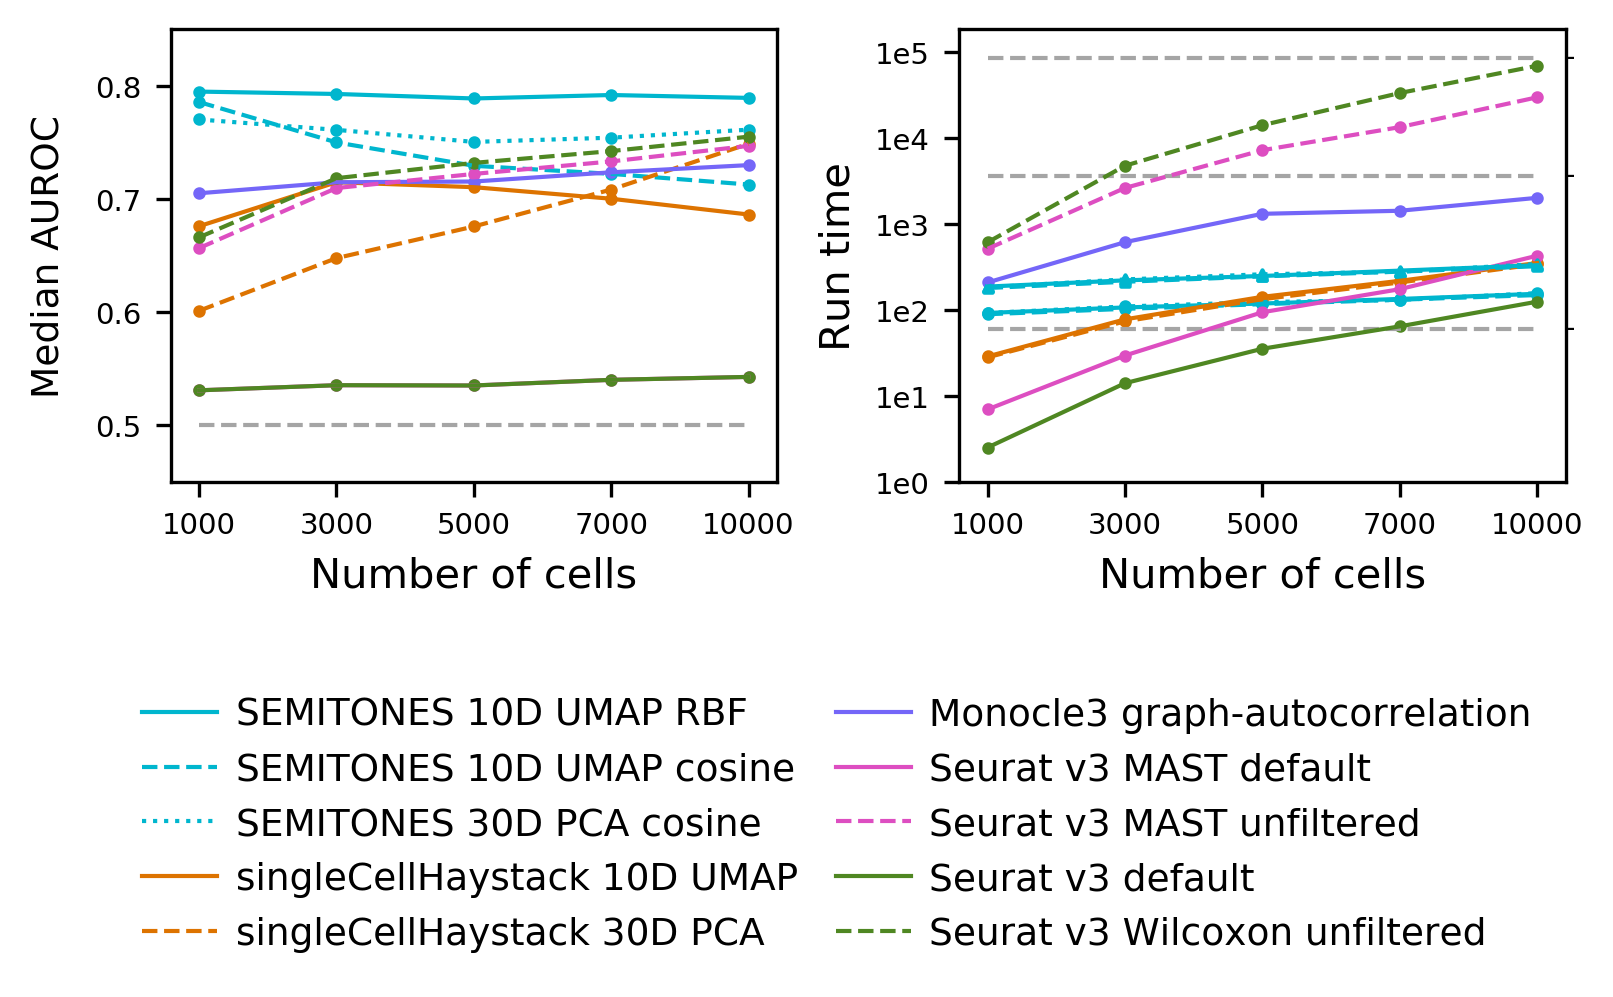

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)
fig.set_figheight(2)
fig.set_figwidth(6)
fig.subplots_adjust(wspace=.3)
x = range(5)

# plots AUCs in the left plot
for method, c, ls, l in zip(methods, colours, linestyles, labels):
    ax1.plot(x, auc_medians.loc[:, method], linewidth=1, color=c,
             ls=ls)
    ax1.scatter(x, auc_medians.loc[:, method], s=4, color=c,
                rasterized=True)
# do make-up y-axis
ax1.set_ylabel("Median AUROC", fontsize=9, labelpad=7)
ax1.set_ylim(0.45, 0.85)
ax1.set_yticks([.5, .6, .7, .8])#, .9])#, 1.])
ax1.set_yticklabels([.5, .6, .7, .8], size=7)#, .9])#, 1.], size=7)
ax1.hlines(0.5, xmin=0, xmax=4, linewidth=1, color="#a5a5a5", ls="--",
          alpha=1)
# do make-up x-axis
ax1.set_xticks(x)
ax1.set_xticklabels([1000, 3000, 5000, 7000, 10000], size=7)
ax1.set_xlabel("Number of cells")

# plot runtime in the right plot
for method, c, ls, l in zip(methods + with_p, colours + colours[0:3],
                            linestyles + linestyles[0:3],
                            labels + labels[0:3]):
    m = "^" if "_p" in method else "o"  # marker for SEMITONES with testing
    l = None if "_p" in method else l  # do not use label for SEMITONES with testing
    # overall times_medians
    ax2.plot(x, times_medians.loc[:, method], linewidth=1, color=c,
             ls=ls, label=l)
    ax2.scatter(x, times_medians.loc[:, method], s=4, color=c,
                marker=m, rasterized=True)
# do make-up y-axis
ax2.set_ylim(1, 60*60*24+1e5)
ax2.set_yscale("log")
ax2.set_yticks([1, 10, 100, 1e3, 1e4, 1e5])
ax2.set_yticklabels(["1e0", "1e1", "1e2", "1e3", "1e4", "1e5"], size=7)
ax2.set_ylabel("Run time")
ax2.hlines(60, xmin=0, xmax=4, linewidth=1, color="#a5a5a5", ls="--",
           alpha=1)  # 1 min line
ax2.hlines(60*60, xmin=0, xmax=4, linewidth=1, color="#a5a5a5", ls="--",
           alpha=1)  # 1 hour line
ax2.hlines(60*60*24, xmin=0, xmax=4, linewidth=1, color="#a5a5a5", ls="--",
           alpha=1)  # 1 day line
ax2.text(4.2, 50, "-", color="black", fontsize=7)  # 1 min tick
ax2.text(4.2, 50*60, "-", color="black", fontsize=7)  # 1 hour tick
ax2.text(4.2, 50*60*24, "-", color="black", fontsize=7)  # 1 day tick
# do make-up x-axis
ax2.set_xticks(x)
ax2.set_xticklabels([1000, 3000, 5000, 7000, 10000], size=7)
ax2.set_xlabel("Number of cells")

leg = plt.legend(ncol=2, fontsize=9, handletextpad=.5,
                 columnspacing=1, bbox_to_anchor=(1, -.4), fancybox=False,
                 frameon=False, markerscale=1.5)